# Assignment for supervisioned modeling - Understanding and Predicting Property Maintenance Fines
### This assignment is based on a data challenge from the Michigan Data Science Team (MDST).

The Michigan Data Science Team (MDST) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences (MSSISS) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. Blight violations are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.



<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
       
### Note: this is the assigment statment from the coursera course
       

# Lets start!
First, we import our traning data, and store in a variable for traning and another for testing.

I will be using pandas for data manipulation, and sklearn libraries for getting our data to traning and testing.

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# storing the data for traning and validation
data = pd.read_csv('train.csv', encoding = 'ISO-8859-1', low_memory=False)

In [2]:
# Looking what our data looks like
print('Number of rows: {}'.format(len(data)))
data.head(2)

Number of rows: 250306


,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0


We got lots of features, and as we can see, they are not the same type. Besides that, not all the features will have meaningfull impact in our modeling. We gonna have to take care of that in the process.

We can think about our columns features and how each one will impact our classification model. From this reflection, we can start to do some feature adjustments. 

When thinking about, we can note that there are features that cause data leakage like 'payment_status', that are supposed to exist only in the future, when the compliance is already paid or not paid. Besides, there are string data types that need to be represented as categorical to be able to go trough our classification model. Lets take care of that.

In [3]:
# First, we clean the data: Some labels in column'compliance' are tagged with nan so we better drop it.
data = data[data['compliance'].notnull()]

# The time between the ticket issue date and the hearing is important whereas the two conditions alone says nothing
# So we transform the data type from string to time type, add a column with that time, and drop the 2 columns 
# that are unuseful.

data['ticket_issued_date'] = pd.to_datetime(data['ticket_issued_date'])
data['hearing_date'] = pd.to_datetime(data['hearing_date'])

data['time_to_pay'] = data['hearing_date'] - data['ticket_issued_date']
data = data.drop(labels=['hearing_date','ticket_issued_date'], axis=1)
data = data[data['time_to_pay'].notnull()]

# transforming the delta timestamp into plain number of days for each cell in our 'time_ti_pay' column
data['time_to_pay'] = data['time_to_pay'].apply(lambda x: x.days)

# some times to pay are negative, which should be impossible, so we delete these rows
data = data[data['time_to_pay'] >= 0]

# rearranging the coluns order for our target column to be in the last index
target = ['compliance']
data = data[[features for features in data if features not in target] + target]

# We need to drop data that cause leakage like: 'compliance_detail','payment_status', 'payment_date'
data = data.drop(labels=['compliance_detail', 'payment_status', 'payment_date', 'balance_due', 'payment_amount',
                 'grafitti_status', 'collection_status'], axis=1)

#dropping unusefull columns like the name of the violator
columns =  ['agency_name', 'inspector_name', 'violator_name',
'violation_street_number', 'violation_street_name',
'violation_zip_code', 'mailing_address_str_number',
'mailing_address_str_name', 'city', 'state', 'zip_code',
'non_us_str_code', 'country', 'violation_code']
data = data.drop(labels=columns, axis=1)

#transforming column string into categorical, then transforming these data into numerical values to model evaluation later
# the cat.codes method assign a number automatically for each category, but we could have done this by hand too,
# as sometimes is much more favorable for modeling performance.
data['disposition'] = data['disposition'].astype('category')
data['disposition'] = data['disposition'].cat.codes 
data['violation_description'] = data['violation_description'].astype('category')
data['violation_description'] = data['violation_description'].cat.codes

# Now, lets take a look in our modified data
data.head()

,ticket_id,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,time_to_pay,compliance
0,22056,69,2,250.0,20.0,10.0,25.0,0.0,0.0,305.0,369,0.0
1,27586,47,3,750.0,20.0,10.0,75.0,0.0,0.0,855.0,378,1.0
5,22046,69,2,250.0,20.0,10.0,25.0,0.0,0.0,305.0,323,0.0
6,18738,48,2,750.0,20.0,10.0,75.0,0.0,0.0,855.0,253,0.0
7,18735,152,2,100.0,20.0,10.0,10.0,0.0,0.0,140.0,251,0.0



The last column, 'compliance', says if people paid the fine (label = 1) or not (label = 0), and will be our target y column of labels.

Now, lest split our data into traning set and testing set and work on the features of our data

In [4]:
# Now, we separate our data into a matrix of features and a column with its labels
X = data.drop('compliance', axis=1)
y = data['compliance']


# and store in train and test variables. We set random state fixed for reproducibility. 
# For good results, 80% of the data for traning and 20% for testing should be enough
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

Finally, we can try to found a model that will give us a score of 75%+ within the AUC metric.
Because its is a problem of binary classification, and the dataset has many features, we gonna try first the logistic regression model.

Also, we are going to use the GridSearchCV method with 10 folds of our training set, for us to optimazing our time in finding the best hyperparameters.
Because we are going to use the cross validation method for training, we can just use the entire labeled datasetX and y that was given to get our averaged test scores of the 10 folders.


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# The higher the penalty multiplier C, more simple and likely to underfit is the model, and for tuning we test
#  C from 0.01 to 100 inlogscale (0.01, 0.1... 100)

# the default solver is lbfgs, but
# we are just gonna try the liblinear solver, because is good with many features and bilinear class data
# and can handle variation in the C parameter
param = { 'C': np.logspace(-2, 2, 5),
        'solver': ['liblinear']}
LR = GridSearchCV(estimator=LogisticRegression(), param_grid=param, scoring='roc_auc', cv=10, return_train_score=True)

LR.fit(X, y)

# We can now visualize our results, selecting the keys that matter for us as columns
pd.DataFrame(data=LR.cv_results_, columns=['param_C', 'mean_train_score','mean_test_score', 'rank_test_score'])

,param_C,mean_train_score,mean_test_score,rank_test_score
0,0.01,0.753463,0.751860,4
1,0.1,0.753218,0.752603,2
2,1.0,0.752432,0.751764,5
3,10.0,0.753815,0.752483,3
4,100.0,0.753173,0.752700,1


In [6]:
# getting the best parameters

print('The best parameters were:\n', LR.best_params_, '\nwith the AUC ROC score of: {:.3f}'.format(LR.best_score_))


The best parameters were:
 {'C': 100.0, 'solver': 'liblinear'} 
with the AUC ROC score of: 0.753


We can note that the results are pretty good, and our first goal of getting a roc_auc score of 0.75+ was achieved.
By default, when modeling this way, we can use the estimator to predict with the best parameters.
Lets plot this area under the curve to visualize the results.




<IPython.core.display.Javascript object>


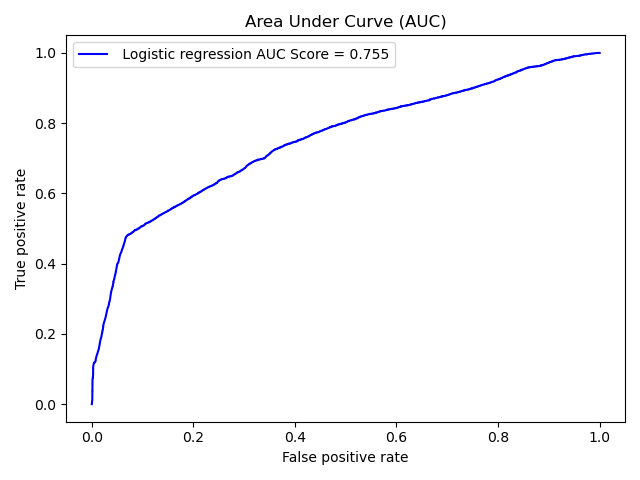

In [63]:
%matplotlib notebook 
from sklearn import metrics
import matplotlib.pyplot as plt

# First, we get our target y series to an array, and store the predicted scores for y
y_predicted_prob = LR.predict_proba(X)[:, 1]

# Then, we need to get the true positives rate and the false positives rate
# For this task, we are going to use the real labels y and the predicted scores
fpr, tpr, _ = metrics.roc_curve(y, y_predicted_prob)
auc_score = metrics.roc_auc_score(y, y_predicted_prob)

# Finally, we now just draw a roc curve

plt.figure()
plt.plot(fpr, tpr, label=' Logistic regression AUC Score = {:.3f}'.format(auc_score), c='b')
plt.title('Area Under Curve (AUC)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.tight_layout()
plt.show()

Now, Im gonna to try a more complex model to see if we can reach a even higher performance within the auc roc metric. The model will be RandomForestClassifier(), because works well when the samples/features rate is high, like our dataset. This model is also good for interpretability, and we can furter visualize what are the most impactful features.

In this data, there are much more people that didnt paid the compliance than people who paid, so we have to account for that class imbalance in our new model. For this, we have to tune the class_weight parameter. It attribute a penalty weight for a class. In our example, as the 1 class has much less samples, we should increase their weight proportionally, so it can impact in a similar way as the 0 class, in our training.

In [11]:
#class imbalance check

print('{:.0%} of all the data are on class 0 (not paid the fine)'.format((len(y[y==0])/len(y))))

93% of all the data the data are on class 0 (not paid the fine)


For the best parameter search, we are going to explore:
Numbers of trees (n_estimators), higher =  + simple model;
Maximum depth of nodes (max_depth), higher = + complex;
Maximum leafs nodes (max_leaf_nodes), higher =  + complex.

The more complex is the model, more it tends to overfit. But a much simpler model can sometimes not be able to do the task, underfitting.

We are going to tune the max leaf nodes in a way were it can have 1 leaf for each sample (None), until 1 leaf for 10000 samples maximum.




In [19]:
from sklearn.ensemble import RandomForestClassifier

# the sum of class weight has to be 1.
class_weight = {0: 0.1,
               1:0.9}

param2 = {'n_estimators': [50, 100, 150],
         'max_depth': [None, 2, 3, 4],
         'max_leaf_nodes':[None, int(len(data)/100), int(len(data)/1000), int(len(data)/10000), 10, 5, 2]}


RF = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=class_weight),
                  param_grid=param2, scoring='roc_auc', cv=10, return_train_score=True)
RF.fit(X, y)



GridSearchCV(cv=10,
             estimator=RandomForestClassifier(class_weight={0: 0.1, 1: 0.9},
                                              n_jobs=-1, random_state=42),
             param_grid={'max_depth': [None, 2, 3, 4],
                         'max_leaf_nodes': [None, 1595, 159, 15, 10, 5, 2],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='roc_auc')

In [21]:
# We can now visualize our results, selecting the keys that matter for us as columns
pd.DataFrame(data=RF.cv_results_,
             columns=['param_n_estimators',
                      'param_max_depth','param_max_leaf_nodes',
                       'mean_train_score','mean_test_score', 'rank_test_score']).sort_values(by='rank_test_score')

,param_n_estimators,param_max_depth,param_max_leaf_nodes,mean_train_score,mean_test_score,rank_test_score
72,50,4,15,0.809072,0.795707,1
69,50,4,159,0.809088,0.795691,2
66,50,4,1595,0.809088,0.795691,2
65,150,4,None,0.809954,0.795630,4
46,100,3,1595,0.803665,0.795256,5
...,...,...,...,...,...,...
5,150,None,1595,0.940195,0.633217,80
4,100,None,1595,0.939609,0.633098,81
2,150,None,None,1.000000,0.483112,82
0,50,None,None,0.999998,0.482913,83


In [40]:
# getting the best parameters

print('The best parameters were:\n', RF.best_params_, '\nwith the AUC ROC score of: {:.3f}'.format(RF.best_score_))


The best parameters were:
 {'max_depth': 4, 'max_leaf_nodes': 15, 'n_estimators': 50} 
with the AUC ROC score of: 0.796


As we can see, we got a nice increase of 4% in our performance, thats great because of how tight and hard it is to increase de performance on this kind of metric.

Lets compare our results now with the previous Logistic Regression Model visualing it.

<IPython.core.display.Javascript object>


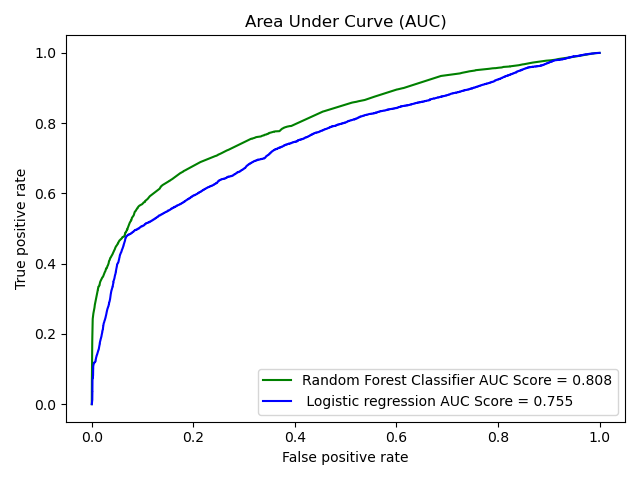

In [64]:
%matplotlib notebook 
# First, we get our target y series to an array, and store the predicted scores for y
y_predicted_prob = RF.predict_proba(X)[:, 1]

# Then, we need to get the true positives rate and the false positives rate
# For this task, we are going to use the real labels y and the predicted scores
fpr1, tpr1, _ = metrics.roc_curve(y, y_predicted_prob)
auc_score1 = metrics.roc_auc_score(y, y_predicted_prob)

# Finally, we now just draw a roc curve


plt.plot(fpr1, tpr1, label='Random Forest Classifier AUC Score = {:.3f}'.format(auc_score1), c='green')
plt.plot(fpr, tpr, label=' Logistic regression AUC Score = {:.3f}'.format(auc_score), c='b')
plt.title('Area Under Curve (AUC)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.tight_layout()
plt.show()

For a final task, lets see wich are the features that have high and low impact for training. This is a nice task to do whenever we can, because we can focus on the most valuable features when engineering our future data.

<IPython.core.display.Javascript object>


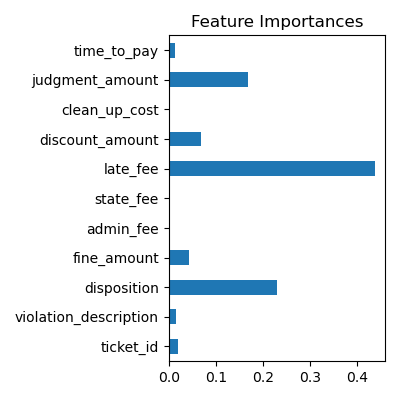

In [68]:
feature_importance = pd.Series(RF.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(4, 4))
feature_importance.plot.barh()
plt.title('Feature Importances')
plt.tight_layout()


So now, our model of choice for future predictions of this data will be the RandomForestClassifier() with param={'max_depth': 4, 'max_leaf_nodes': 15, 'n_estimators': 50}.

For this particular task on the Coursera course, I passed whith a auc_roc of 0.78, wich game me the max grade!